# Evaluate Autoencoder Model
This notebook conducts a qualitative analysis of the best autoencoder configuration found via the random search conducted in `ae_sweep.py`.

The reconstruction error, aswell as the latent space are plotted.

In [19]:
config = {
    "train_test_split": 0.95,
    "random_state": 1,
    "loss": "msle",
    "optimizer": "adam",
    "epochs": 20,
    "batch_size": 789,
    "architecture": "8_4",
    "activation": "softmax",
    "latent_dimension": 2,
    "learning_rate": 0.001,
    "features": [
        "std_rush_order",
        "avg_rush_order",
        "std_trades",
        "std_volume",
        "avg_volume",
        "std_price",
        "avg_price",
        "avg_price_max",
    ],
}

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    f1_score,
    recall_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
)
from tensorflow.keras.optimizers import Adam, SGD
from ae_models import Autoencoder_8_4, Autoencoder_8_6_4, Autoencoder_8_7_5
import seaborn as sns

In [21]:
def create_datasets():
    time_freq = "15S"
    computed_data = pd.read_csv(
        "../../data/la_morgia_data/features_" + time_freq + ".csv.gz",
        parse_dates=["date"],
    )

    normal_datapoints = computed_data[computed_data["gt"] == 0]
    anomaly_datapoints = computed_data[computed_data["gt"] == 1]

    # randomness
    train_set = normal_datapoints.sample(frac=0.95, random_state=1)

    test_set_normal = normal_datapoints.drop(train_set.index)
    test_sets = [test_set_normal, anomaly_datapoints]
    test_set = pd.concat(test_sets)

    features = [
        "std_rush_order",
        "avg_rush_order",
        "std_trades",
        "std_volume",
        "avg_volume",
        "std_price",
        "avg_price",
        "avg_price_max",
        # "hour_sin",
        # "hour_cos",
        # "minute_sin",
        # "minute_cos",
    ]

    x_train = train_set[features]
    x_test = test_set[features]
    y_train = train_set["gt"]
    y_test = test_set["gt"]

    return x_train, y_train, x_test, y_test

In [22]:
def set_optimizer(optimizer, learning_rate):
    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate)

    return optimizer

In [23]:
def find_threshold(model, x_train):
    reconstructions = model.predict(x_train)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train)

    threshold = np.mean(reconstruction_errors.numpy()) + np.std(
        reconstruction_errors.numpy()
    )
    return threshold

In [24]:
def get_predictions(model, x_test, threshold):
    reconstructions = model.predict(x_test)
    errors = tf.keras.losses.msle(reconstructions, x_test)

    # 1 = anomaly, 0 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    return preds, errors

In [25]:
def log_metrics(predictions, threshold):
    overall_score = (
        accuracy_score(y_test, predictions)
        + precision_score(y_test, predictions)
        + recall_score(y_test, predictions)
        + f1_score(y_test, predictions, average="macro")
        + f1_score(y_test, predictions, average="micro")
    )

    print(
        {
            "Accuracy": accuracy_score(y_test, predictions),
            "Precision": precision_score(y_test, predictions),
            "Recall": recall_score(y_test, predictions),
            "F1_Macro": f1_score(y_test, predictions, average="macro"),
            "F1_Micro": f1_score(y_test, predictions, average="micro"),
            "Overall": overall_score,
            "Confusion Matrix": confusion_matrix(y_test, predictions),
            "threshold": threshold,
        }
    )

In [26]:
def set_model_architechture(architecture, input_units, latent_dimension, activation):
    if architecture == "8_6_4":
        return Autoencoder_8_6_4(input_units, latent_dimension, activation)
    if architecture == "8_7_5":
        return Autoencoder_8_7_5(input_units, latent_dimension, activation)
    if architecture == "8_4":
        return Autoencoder_8_4(input_units, latent_dimension, activation)

In [27]:
def run_train(config):
    input_units = x_train.shape[1]
    autoencoder = set_model_architechture(
        config["architecture"],
        input_units,
        config["latent_dimension"],
        config["activation"],
    )
    optimizer = set_optimizer(config["optimizer"], config["learning_rate"])
    autoencoder.compile(loss=config["loss"], optimizer=optimizer)

    autoencoder.predict(x_train[:1])
    autoencoder.load_weights("./best_model/best_ae_weights.h5")
    print(autoencoder.summary())

    return autoencoder

In [28]:
x_train, y_train, x_test, y_test = create_datasets()
autoencoder = run_train(config)
print(autoencoder.summary())

1/1 [==============================] - 0s 216ms/step
Model: "autoencoder_8_4_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 2)                 118       
                                                                 
 sequential_3 (Sequential)   (None, 8)                 52        
                                                                 
Total params: 170 (680.00 Byte)
Trainable params: 170 (680.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "autoencoder_8_4_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 2)                 118       
                                                                 
 sequential_3 (Sequential)   (None, 8)                 52 

In [29]:
threshold = find_threshold(autoencoder, x_train)
predictions, reconstruction_errors = get_predictions(autoencoder, x_test, 2 * threshold)
log_metrics(predictions, threshold)

923/923 [==============================] - 2s 2ms/step
{'Accuracy': 0.9987460177590999, 'Precision': 0.9516129032258065, 'Recall': 0.9305993690851735, 'F1_Macro': 0.97017755565508, 'F1_Micro': 0.9987460177590999, 'Overall': 4.849881863484259, 'Confusion Matrix': array([[29174,    15],
       [   22,   295]], dtype=int64), 'threshold': 0.0008070712930851276}


In [30]:
# plot reconstruction errors

print(threshold)
errors = tf.Variable(reconstruction_errors).numpy().tolist()
labels = list(y_test)
offsets = np.random.uniform(-0.1, 0.1, size=len(errors))

print(f"Highest reconstruction error: {max(errors)}")

errors_df = pd.DataFrame(
    {f"reconstruction_error": errors, "x_offset": offsets, "label": labels}
)
errors_df = errors_df.sort_values(by="label", ascending=False)
print(errors_df.sample(10))

print(y_test.value_counts())
print(errors_df["label"].value_counts())
errors_df["label"] = errors_df["label"].map({0: "Normal", 1: "Anomaly"})

0.0008070712930851276
Highest reconstruction error: 3.4422686572492047
       reconstruction_error  x_offset  label
7539           5.159800e-08  0.080741      0
579            1.646511e-07  0.040625      0
15965          3.224727e-07  0.078844      0
20339          4.965735e-08  0.019294      0
17392          1.413920e-06 -0.049716      0
15517          7.922315e-07  0.043450      0
27924          2.827879e-06 -0.063300      0
12256          5.684413e-07  0.037086      0
17875          1.953970e-07 -0.091047      0
10482          3.983266e-08 -0.066812      0
gt
0    29189
1      317
Name: count, dtype: int64
label
0    29189
1      317
Name: count, dtype: int64


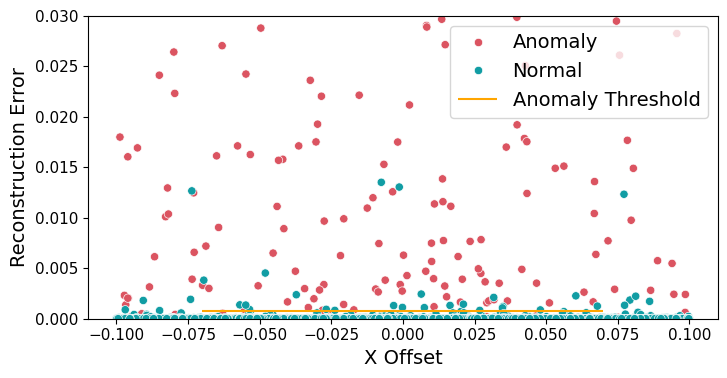

In [31]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.figure(figsize=(7.5, 4))

# Plotting the data points with colors based on the label
scatter_plot = sns.scatterplot(
    data=errors_df,
    x="x_offset",
    y="reconstruction_error",
    hue="label",
    palette=["#DB5461", "#119DA4"],
    legend="brief",
)

# legend_labels = ["Normal", "Anomaly"]
# for t, l in zip(scatter_plot.legend_.texts, legend_labels):
#    t.set_text(l)

plt.hlines(
    y=threshold,
    xmin=-0.07,
    xmax=0.07,
    colors="orange",
    linestyles="-",
    lw=1.5,
    label="Anomaly Threshold",
)

# Setting titles and labels
plt.ylim(0, 0.03)  # Adjust these values based on the desired y-axis rang
# plt.title("Scatter Plot of Reconstruction Error")
plt.xlabel("X Offset")
plt.ylabel("Reconstruction Error")

# Fixing the legend to display custom labels correctly
handles, labels = scatter_plot.get_legend_handles_labels()
labels[-1] = "Anomaly Threshold"  # Rename the last legend label
scatter_plot.legend(handles=handles, labels=labels)


# Show the plot
plt.tight_layout()
plt.savefig("./reconstruction_errors_ae.png")
plt.show()

In [32]:
# plot latent space
latent_model = tf.keras.Model(
    inputs=autoencoder.encoder.input, outputs=autoencoder.encoder.layers[-1].output
)

# Now you can use this model to get the latent space representations
latent_values = latent_model.predict(x_test)
print(latent_values)

# pca = PCA(n_components=2)
# X_transform = pca.fit_transform(latent_values)
X_transform = latent_values
labels = list(y_test)

print(X_transform)
print(labels)


label_names = {
    1: "Anomaly",
    0: "Normal",
}
labels_named = np.vectorize(label_names.get)(labels)


palette_named = {"Anomaly": "#DB5461", "Normal": "#119DA4"}
# errors_df = pd.DataFrame({f"latent_values": X_transform, "label": labels})
# print(errors_df.sample(10))

923/923 [==============================] - 3s 3ms/step
[[-0.10827953  0.07200234]
 [-0.10740431  0.07172449]
 [-0.10811813  0.07192244]
 ...
 [-1.440342    0.4625528 ]
 [-0.14345877  0.08282582]
 [-1.4403541   0.46255612]]
[[-0.10827953  0.07200234]
 [-0.10740431  0.07172449]
 [-0.10811813  0.07192244]
 ...
 [-1.440342    0.4625528 ]
 [-0.14345877  0.08282582]
 [-1.4403541   0.46255612]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

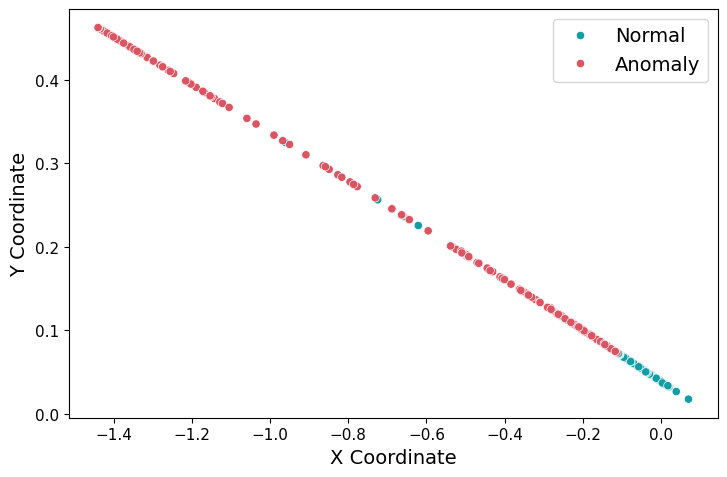

In [33]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.figure(figsize=(7.5, 5))

sns.scatterplot(
    x=X_transform[:, 0],
    y=X_transform[:, 1],
    hue=labels_named,
    palette=palette_named,
    legend="brief",
)


# plt.title("Latent Space of AE")


plt.xlabel("X Coordinate")


plt.ylabel("Y Coordinate")


# plt.xlim(-3, 5)


# plt.ylim(-3, 10)


plt.tight_layout()
plt.savefig("./latent_space_ae.png")


plt.show()

923/923 [==============================] - 3s 3ms/step


C:\Users\Denis\AppData\Local\Temp\ipykernel_10560\648058580.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Value", y="Feature", data=df_sorted, palette=palette)


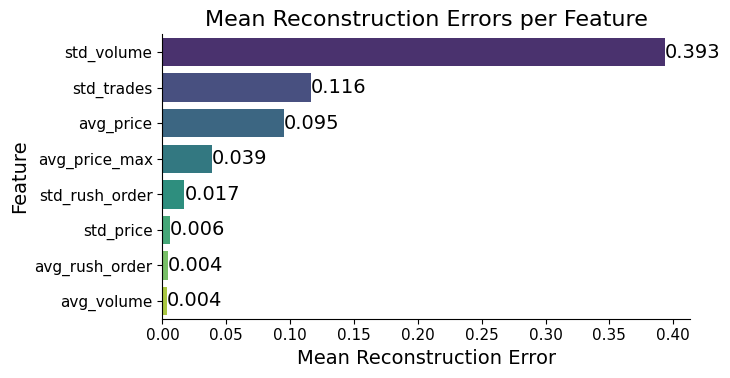

In [34]:
# Mean Reconstruction Errors


# Predict the reconstructed outputs for the test set

x_test_pred = autoencoder.predict(x_test)


# Calculate the reconstruction error for each sample


# Here, we use Mean Squared Error (MSE) as the metric


reconstruction_errors = np.mean(np.square(x_test - x_test_pred), axis=1)


# If you need errors for each feature separately, not the mean error for each sample:


feature_wise_errors = np.square(x_test - x_test_pred)


column_means = feature_wise_errors.mean().tolist()


column_names = feature_wise_errors.columns.tolist()


df = pd.DataFrame({"Feature": column_names, "Value": column_means})


# Sort the DataFrame by 'Value' in descending order for better visibility


df_sorted = df.sort_values("Value", ascending=False)


# Create a bar plot with sorted values


plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.figure(figsize=(7.5, 4))


palette = sns.color_palette("viridis", len(df_sorted))
barplot = sns.barplot(x="Value", y="Feature", data=df_sorted, palette=palette)


plt.title("Mean Reconstruction Errors per Feature")


plt.xlabel("Mean Reconstruction Error")


plt.ylabel("Feature")


# Annotate each bar with its value
sns.despine()

for p in barplot.patches:
    width = p.get_width()  # get the width of each bar
    barplot.text(
        width,  # x-coordinate for text
        p.get_y() + p.get_height() / 2,  # y-coordinate for text
        f"{width:,.3f}",  # the text to be displayed in comma-separated format
        va="center",  # vertical alignment of text
    )

plt.tight_layout()
plt.savefig("./mean_reconstruction_errors.png")
plt.show()